In [1]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import itertools

import sys
import os
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import six
from abc import ABCMeta
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
from xgboost import plot_importance
from xgboost import XGBClassifier

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_csv('./Child(preprocessing).csv',encoding = 'cp949')
df

/Users/Moon/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (24,25,28,29,30,32,33,34,35,36,40,43,49,53,54,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,개별사건번호,피해아동 대상자ID,학대행위자 대상자ID,성별,생년월일,내국인여부,교육기관,최종 학력,직업 유형,거주상태,...,재신고 관리 기관,재신고 이전 사건,동일신고 여부.1,동일신고 이전 사건,보호자 학대 여부,아동 관계 구분코드,아동 동거 여부.1,특별관리유형,학대 혐의 여부,학대 유형
0,5722572220181200160001,CASRCP20190100282,CASRCP20190100283,M,20051005.0,내국인,NaN,재학중,중학교,자택,...,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,Y,양육관련상담
1,6603660320181200090001,CASRCP20190101182,CASRCP20190101183,F,20041107.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,N,NaN,NaN,NaN,N,NaN,N,NaN
2,6002600220181200040001,CASRCP20190100497,CASRCP20190100498,F,20040218.0,내국인,NaN,재학중,중학교,NaN,...,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,N,NaN
3,5202520220181200080001,CASRCP20190301533,CASRCP20190301534,M,20030316.0,내국인,NaN,재학중,고등학교,NaN,...,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,Y,이혼 및 양육권 소송상담
4,5601560120181200130001,CASRCP20190100151,CASRCP20190100153,M,20061005.0,내국인,NaN,재학중,초등학교,월세,...,NaN,NaN,N,NaN,NaN,NaN,N,NaN,Y,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122671,1201120120140100010001,CASRCP20130310175,CASRCP20140220184,F,NaN,내국인,NaN,고등중퇴,고등학교,NaN,...,전라북도아동보호전문기관,1.201201e+13,N,NaN,NaN,NaN,Y,NaN,Y,이혼 및 양육권 소송상담
122672,1001100120140100010001,CASRCP20140110966,CASRCP20140121028,M,19960506.0,내국인,NaN,NaN,NaN,자택,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,N,NaN
122673,1001100120140100020001,CASRCP20140110878,CASRCP20140121028,F,19990623.0,내국인,NaN,NaN,NaN,자택,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,N,NaN
122674,1502150220140100020001,CASRCP20110610831,CASRCP20110620594,M,20021029.0,내국인,NaN,NaN,NaN,전세,...,경남서부아동보호전문기관,1.502201e+13,NaN,NaN,NaN,NaN,N,NaN,Y,NaN


In [4]:
df = df[['성별', '거주상태', '가족 유형', '가구 소득 구분코드', '기초생활수급 유형',
       '재신고 유형', '신고접수 구분', '피해아동 상태 구분', '아동 동거 여부', '재신고 여부', '통계 거점',
       '학대 혐의 여부', '생년월일', '재신고 이전 사건']]

In [5]:
a = []
for i in df['재신고 이전 사건'].isnull():
    if i == True:
        a.append(1)
    else:
        a.append(0)

In [6]:
# df = df.drop(['재신고 이전 사건 '], axis = 1)
df['재신고 이전 사건 '] = pd.Series(a)
df.head()

/Users/Moon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,성별,거주상태,가족 유형,가구 소득 구분코드,기초생활수급 유형,재신고 유형,신고접수 구분,피해아동 상태 구분,아동 동거 여부,재신고 여부,통계 거점,학대 혐의 여부,생년월일,재신고 이전 사건,재신고 이전 사건
0,M,자택,친부모가정,NaN,비수급권대상,NaN,경찰접수,NaN,동거,N,경기,Y,20051005.0,NaN,1
1,F,NaN,NaN,NaN,NaN,NaN,경찰접수,NaN,비동거,N,제주,N,20041107.0,NaN,1
2,F,NaN,친부모가정,250만원이상-300만원미만,비수급권대상,NaN,아동보호전문기관접수,NaN,동거,N,충북,N,20040218.0,NaN,1
3,M,NaN,친부모가정,NaN,비수급권대상,NaN,경찰접수,NaN,동거,N,대구,Y,20030316.0,NaN,1
4,M,월세,친부모가정,NaN,NaN,NaN,경찰접수,NaN,동거,N,울산,Y,20061005.0,NaN,1


In [7]:
df = df.fillna(0)

In [8]:
X = df[['성별', '거주상태', '가족 유형', '가구 소득 구분코드', '기초생활수급 유형',
       '재신고 유형', '신고접수 구분', '피해아동 상태 구분', '아동 동거 여부', '재신고 여부', '통계 거점',
       '학대 혐의 여부']]
y = df['재신고 이전 사건 ']
#y를 0,1을 바꿔서 해보고 모델의 신뢰성을 검증해보기 

In [9]:
data_dummies = pd.get_dummies(X)

In [10]:
data_dummies

,성별_0,성별_F,성별_M,성별_Z,거주상태_0,거주상태_기타,거주상태_무상,거주상태_보증금(전세)+월세,거주상태_보호시설,거주상태_영구임대아파트 또는 영구임대주택,...,통계 거점_울산,통계 거점_인천,통계 거점_전남,통계 거점_전북,통계 거점_제주,통계 거점_중앙,통계 거점_충남,통계 거점_충북,학대 혐의 여부_N,학대 혐의 여부_Y
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122671,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
122672,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
122673,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
122674,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
for i in df.columns:
    print(i, ':', df[i].unique())

성별 : ['M' 'F' 'Z' 0]
거주상태 : ['자택' 0 '월세' '기타' '전세' '보증금(전세)+월세' '보호시설' '영구임대아파트  또는 영구임대주택' '무상']
가족 유형 : ['친부모가정' 0 '재혼가정' '모자가족(이혼)' '부자가족(별거)' '기타' '미혼부·모가정' '부자가족(이혼)' '시설보호'
 '동거(사실혼포함)' '모자가족(별거)' '친인척보호' '부자가족(가출)' '모자가족(사별)' '입양가정' '부자가족(사별)'
 '모자가족(가출)' '위탁가정' '소년소녀가정']
가구 소득 구분코드 : [0 '250만원이상-300만원미만' '150만원이상-200만원미만' '300만원이상' '200만원이상-250만원미만'
 '50만원미만' '100만원이상-150만원미만' '50만원이상~100만원미만']
기초생활수급 유형 : ['비수급권대상' 0 '수급권대상']
재신고 유형 : [0 '동일센터 사례종결후 재신고' '사례진행중 재신고' '타센터 사례종결후 재신고' '일반상담 후 재신고']
신고접수 구분 : ['경찰접수' '아동보호전문기관접수']
피해아동 상태 구분 : [0 '해당사항없음' '중상해(의식불명 포함)' '아동사망']
아동 동거 여부 : ['동거' '비동거' 0]
재신고 여부 : ['N' 'Y']
통계 거점 : ['경기' '제주' '충북' '대구' '울산' '경북' '강원' '대전' '부산' '서울' '인천' '전남' '광주' '전북'
 '충남' '경남' '중앙' '세종']
학대 혐의 여부 : ['Y' 'N']
생년월일 : [20051005. 20041107. 20040218. ... 19960203. 19970127. 19960506.]
재신고 이전 사건 : [0.00000000e+00 1.30120181e+13 8.11201607e+12 ... 1.20120130e+13
 1.50220111e+13 1.50220111e+13]
재신고 이전 사건  : [1 0]


In [12]:
print(data_dummies.shape)
print(y.shape)
#깔끔

(122676, 79)
(122676,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_dummies,y, test_size = 0.3, random_state = 10)

In [14]:
X_train = X_train.dropna()

In [15]:
print(X_train.shape)
print(y_train.shape)

(85873, 79)
(85873,)


In [16]:
X_train.columns

Index(['성별_0', '성별_F', '성별_M', '성별_Z', '거주상태_0', '거주상태_기타', '거주상태_무상',
       '거주상태_보증금(전세)+월세', '거주상태_보호시설', '거주상태_영구임대아파트  또는 영구임대주택', '거주상태_월세',
       '거주상태_자택', '거주상태_전세', '가족 유형_0', '가족 유형_기타', '가족 유형_동거(사실혼포함)',
       '가족 유형_모자가족(가출)', '가족 유형_모자가족(별거)', '가족 유형_모자가족(사별)', '가족 유형_모자가족(이혼)',
       '가족 유형_미혼부·모가정', '가족 유형_부자가족(가출)', '가족 유형_부자가족(별거)', '가족 유형_부자가족(사별)',
       '가족 유형_부자가족(이혼)', '가족 유형_소년소녀가정', '가족 유형_시설보호', '가족 유형_위탁가정',
       '가족 유형_입양가정', '가족 유형_재혼가정', '가족 유형_친부모가정', '가족 유형_친인척보호',
       '가구 소득 구분코드_0', '가구 소득 구분코드_100만원이상-150만원미만',
       '가구 소득 구분코드_150만원이상-200만원미만', '가구 소득 구분코드_200만원이상-250만원미만',
       '가구 소득 구분코드_250만원이상-300만원미만', '가구 소득 구분코드_300만원이상', '가구 소득 구분코드_50만원미만',
       '가구 소득 구분코드_50만원이상~100만원미만', '기초생활수급 유형_0', '기초생활수급 유형_비수급권대상',
       '기초생활수급 유형_수급권대상', '재신고 유형_0', '재신고 유형_동일센터 사례종결후 재신고',
       '재신고 유형_사례진행중 재신고', '재신고 유형_일반상담 후 재신고', '재신고 유형_타센터 사례종결후 재신고',
       '신고접수 구분_경찰접수', '신고접수 구분_아동보호전문기관접수', '피해아동 상태 구분_0', '피해아동 상태 구분_아동사망',
    

In [17]:
X_test.columns

Index(['성별_0', '성별_F', '성별_M', '성별_Z', '거주상태_0', '거주상태_기타', '거주상태_무상',
       '거주상태_보증금(전세)+월세', '거주상태_보호시설', '거주상태_영구임대아파트  또는 영구임대주택', '거주상태_월세',
       '거주상태_자택', '거주상태_전세', '가족 유형_0', '가족 유형_기타', '가족 유형_동거(사실혼포함)',
       '가족 유형_모자가족(가출)', '가족 유형_모자가족(별거)', '가족 유형_모자가족(사별)', '가족 유형_모자가족(이혼)',
       '가족 유형_미혼부·모가정', '가족 유형_부자가족(가출)', '가족 유형_부자가족(별거)', '가족 유형_부자가족(사별)',
       '가족 유형_부자가족(이혼)', '가족 유형_소년소녀가정', '가족 유형_시설보호', '가족 유형_위탁가정',
       '가족 유형_입양가정', '가족 유형_재혼가정', '가족 유형_친부모가정', '가족 유형_친인척보호',
       '가구 소득 구분코드_0', '가구 소득 구분코드_100만원이상-150만원미만',
       '가구 소득 구분코드_150만원이상-200만원미만', '가구 소득 구분코드_200만원이상-250만원미만',
       '가구 소득 구분코드_250만원이상-300만원미만', '가구 소득 구분코드_300만원이상', '가구 소득 구분코드_50만원미만',
       '가구 소득 구분코드_50만원이상~100만원미만', '기초생활수급 유형_0', '기초생활수급 유형_비수급권대상',
       '기초생활수급 유형_수급권대상', '재신고 유형_0', '재신고 유형_동일센터 사례종결후 재신고',
       '재신고 유형_사례진행중 재신고', '재신고 유형_일반상담 후 재신고', '재신고 유형_타센터 사례종결후 재신고',
       '신고접수 구분_경찰접수', '신고접수 구분_아동보호전문기관접수', '피해아동 상태 구분_0', '피해아동 상태 구분_아동사망',
    

In [18]:
X_train.isnull().sum()

성별_0          0
성별_F          0
성별_M          0
성별_Z          0
거주상태_0        0
             ..
통계 거점_중앙      0
통계 거점_충남      0
통계 거점_충북      0
학대 혐의 여부_N    0
학대 혐의 여부_Y    0
Length: 79, dtype: int64

### Decision Tree

In [20]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [21]:
sc = StandardScaler()
sc.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
from sklearn import tree
Child_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=10, max_features= 3)
Child_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')

In [23]:
from sklearn.metrics import accuracy_score

y_pred_tr = Child_tree.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_tr))

Accuracy: 0.90


### XGBOOST

In [24]:
epoch = 100
learning_rate = 0.05
gamma = 0
subsampling = 0.6
max_depth = 7
xgb_model = xgboost.XGBRegressor(n_estimators = 100, learning_rate = learning_rate, 
                                 gamma = gamma, subsampling = subsampling,
                                 colsample_bytree = 1, max_depth = max_depth)

print(X_train.shape, y_train.shape)
xgb_model.fit(X_train, y_train)

(85873, 79) (85873,)
[21:57:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { subsampling } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, subsampling=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

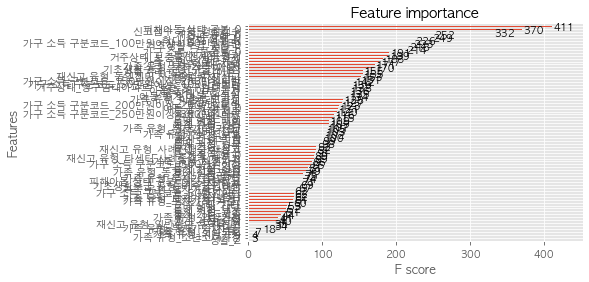

In [25]:
xgboost.plot_importance(xgb_model)

In [26]:
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [27]:
params = {'max_depth' : 4,
         'eta' : 0.005, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 ,
         'sub_sample' : 0.3,
         'min_child_weight' : 5,
         'num_boost_around' : 10}

num_rounds = 1000

In [28]:
wlist = [(dtrain, 'train'), (dtest,'eval')]
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[21:57:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stoppings, num_boost_around, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.68860	eval-logloss:0.68854
[1]	train-logloss:0.68401	eval-logloss:0.68402
[2]	train-logloss:0.67957	eval-logloss:0.67955
[3]	train-logloss:0.67504	eval-logloss:0.67511
[4]	train-logloss:0.67067	eval-logloss:0.67065
[5]	train-logloss:0.66622	eval-logloss:0.66627
[6]	train-logloss:0.66192	eval-logloss:0.66203
[7]	train-logloss:0.65771	eval-logloss:0.65772
[8]	train-logloss:0.65343	eval-logloss:0.65348
[9]	train-logloss:0.64926	eval-logloss:0.64930
[10]	train-logloss:0.64509	eval-logloss:0.64515
[11]	train-logloss:0.64096	eval-logloss:0.64104
[12]	train-logloss:0.63699	eval-logloss

[162]	train-logloss:0.28872	eval-logloss:0.28904
[163]	train-logloss:0.28746	eval-logloss:0.28780
[164]	train-logloss:0.28624	eval-logloss:0.28658
[165]	train-logloss:0.28496	eval-logloss:0.28530
[166]	train-logloss:0.28372	eval-logloss:0.28407
[167]	train-logloss:0.28249	eval-logloss:0.28287
[168]	train-logloss:0.28128	eval-logloss:0.28162
[169]	train-logloss:0.28010	eval-logloss:0.28043
[170]	train-logloss:0.27886	eval-logloss:0.27922
[171]	train-logloss:0.27767	eval-logloss:0.27803
[172]	train-logloss:0.27650	eval-logloss:0.27685
[173]	train-logloss:0.27529	eval-logloss:0.27568
[174]	train-logloss:0.27417	eval-logloss:0.27451
[175]	train-logloss:0.27298	eval-logloss:0.27333
[176]	train-logloss:0.27184	eval-logloss:0.27220
[177]	train-logloss:0.27067	eval-logloss:0.27104
[178]	train-logloss:0.26954	eval-logloss:0.26990
[179]	train-logloss:0.26838	eval-logloss:0.26876
[180]	train-logloss:0.26731	eval-logloss:0.26765
[181]	train-logloss:0.26615	eval-logloss:0.26653
[182]	train-logloss:

[330]	train-logloss:0.15957	eval-logloss:0.16026
[331]	train-logloss:0.15914	eval-logloss:0.15984
[332]	train-logloss:0.15872	eval-logloss:0.15942
[333]	train-logloss:0.15829	eval-logloss:0.15900
[334]	train-logloss:0.15787	eval-logloss:0.15858
[335]	train-logloss:0.15745	eval-logloss:0.15816
[336]	train-logloss:0.15703	eval-logloss:0.15774
[337]	train-logloss:0.15660	eval-logloss:0.15733
[338]	train-logloss:0.15619	eval-logloss:0.15693
[339]	train-logloss:0.15580	eval-logloss:0.15652
[340]	train-logloss:0.15539	eval-logloss:0.15611
[341]	train-logloss:0.15497	eval-logloss:0.15571
[342]	train-logloss:0.15459	eval-logloss:0.15532
[343]	train-logloss:0.15418	eval-logloss:0.15492
[344]	train-logloss:0.15379	eval-logloss:0.15453
[345]	train-logloss:0.15339	eval-logloss:0.15414
[346]	train-logloss:0.15302	eval-logloss:0.15375
[347]	train-logloss:0.15262	eval-logloss:0.15336
[348]	train-logloss:0.15223	eval-logloss:0.15297
[349]	train-logloss:0.15184	eval-logloss:0.15259
[350]	train-logloss:

[498]	train-logloss:0.11462	eval-logloss:0.11578
[499]	train-logloss:0.11448	eval-logloss:0.11563
[500]	train-logloss:0.11433	eval-logloss:0.11548
[501]	train-logloss:0.11417	eval-logloss:0.11534
[502]	train-logloss:0.11404	eval-logloss:0.11519
[503]	train-logloss:0.11388	eval-logloss:0.11504
[504]	train-logloss:0.11373	eval-logloss:0.11489
[505]	train-logloss:0.11359	eval-logloss:0.11475
[506]	train-logloss:0.11344	eval-logloss:0.11462
[507]	train-logloss:0.11330	eval-logloss:0.11447
[508]	train-logloss:0.11317	eval-logloss:0.11433
[509]	train-logloss:0.11302	eval-logloss:0.11420
[510]	train-logloss:0.11287	eval-logloss:0.11406
[511]	train-logloss:0.11273	eval-logloss:0.11391
[512]	train-logloss:0.11259	eval-logloss:0.11378
[513]	train-logloss:0.11246	eval-logloss:0.11364
[514]	train-logloss:0.11232	eval-logloss:0.11351
[515]	train-logloss:0.11217	eval-logloss:0.11338
[516]	train-logloss:0.11205	eval-logloss:0.11324
[517]	train-logloss:0.11191	eval-logloss:0.11311
[518]	train-logloss:

[666]	train-logloss:0.09896	eval-logloss:0.10049
[667]	train-logloss:0.09891	eval-logloss:0.10044
[668]	train-logloss:0.09885	eval-logloss:0.10039
[669]	train-logloss:0.09880	eval-logloss:0.10035
[670]	train-logloss:0.09876	eval-logloss:0.10030
[671]	train-logloss:0.09870	eval-logloss:0.10025
[672]	train-logloss:0.09864	eval-logloss:0.10020
[673]	train-logloss:0.09860	eval-logloss:0.10016
[674]	train-logloss:0.09855	eval-logloss:0.10010
[675]	train-logloss:0.09851	eval-logloss:0.10006
[676]	train-logloss:0.09845	eval-logloss:0.10002
[677]	train-logloss:0.09840	eval-logloss:0.09997
[678]	train-logloss:0.09836	eval-logloss:0.09992
[679]	train-logloss:0.09831	eval-logloss:0.09988
[680]	train-logloss:0.09827	eval-logloss:0.09983
[681]	train-logloss:0.09821	eval-logloss:0.09979
[682]	train-logloss:0.09817	eval-logloss:0.09975
[683]	train-logloss:0.09813	eval-logloss:0.09970
[684]	train-logloss:0.09807	eval-logloss:0.09966
[685]	train-logloss:0.09803	eval-logloss:0.09961
[686]	train-logloss:

[834]	train-logloss:0.09353	eval-logloss:0.09550
[835]	train-logloss:0.09351	eval-logloss:0.09548
[836]	train-logloss:0.09348	eval-logloss:0.09546
[837]	train-logloss:0.09348	eval-logloss:0.09545
[838]	train-logloss:0.09344	eval-logloss:0.09542
[839]	train-logloss:0.09343	eval-logloss:0.09541
[840]	train-logloss:0.09341	eval-logloss:0.09540
[841]	train-logloss:0.09339	eval-logloss:0.09537
[842]	train-logloss:0.09337	eval-logloss:0.09536
[843]	train-logloss:0.09334	eval-logloss:0.09534
[844]	train-logloss:0.09333	eval-logloss:0.09532
[845]	train-logloss:0.09330	eval-logloss:0.09531
[846]	train-logloss:0.09329	eval-logloss:0.09529
[847]	train-logloss:0.09327	eval-logloss:0.09527
[848]	train-logloss:0.09325	eval-logloss:0.09526
[849]	train-logloss:0.09323	eval-logloss:0.09524
[850]	train-logloss:0.09321	eval-logloss:0.09522
[851]	train-logloss:0.09320	eval-logloss:0.09521
[852]	train-logloss:0.09317	eval-logloss:0.09520
[853]	train-logloss:0.09316	eval-logloss:0.09518
[854]	train-logloss:

In [29]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.994 0.049 0.989 0.029 0.947 0.942 0.015 0.97  0.969 0.987]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 0, 1, 1, 1]


In [30]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [31]:
get_clf_eval(y_test, preds)

오차행렬:
 [[ 3689   688]
 [   88 32338]]

정확도: 0.9789
정밀도: 0.9792
재현율: 0.9973
F1: 0.9881
AUC: 0.9201


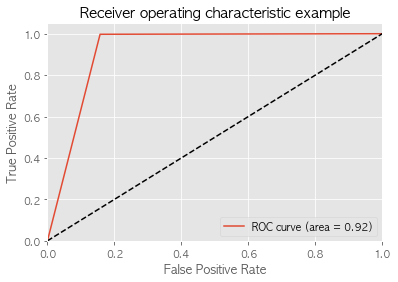

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Random Forest

In [33]:
forest = RandomForestClassifier(n_estimators=100,random_state=0,
                                max_depth = 5)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [34]:
print("훈련 세트 정확도 : {:.3f}".format(forest.score(X_train,y_train)))
print("테스트 세트 정확도 : {:.3f}".format(forest.score(X_test,y_test)))

훈련 세트 정확도 : 0.979
테스트 세트 정확도 : 0.979


In [35]:
pred_probs = forest.predict(X_test)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[1 0 1 0 1 1 0 1 1 1]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 0, 1, 1, 1]


In [36]:
pred_probs

array([1, 0, 1, ..., 1, 1, 1])

In [37]:
get_clf_eval(y_test, preds)

오차행렬:
 [[ 3689   688]
 [   88 32338]]

정확도: 0.9789
정밀도: 0.9792
재현율: 0.9973
F1: 0.9881
AUC: 0.9201


In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

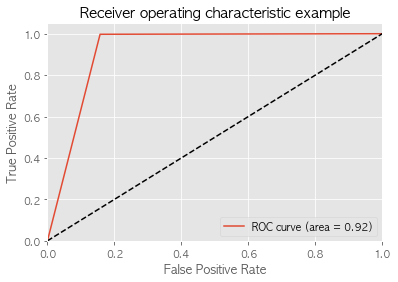

In [39]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [40]:
def plot_feature_importances_child(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_)
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)


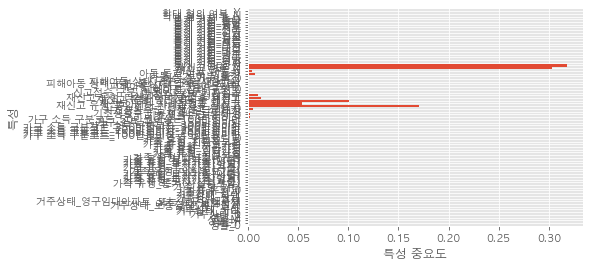

In [41]:
plot_feature_importances_child(forest)

### ANN(못하게뜨뮤ㅠ)

In [42]:
import tensorflow as tf
from tensorflow import keras

In [43]:
tf.__version__

'2.0.1'

In [44]:
model = Sequential()

In [45]:
model = Sequential([
    Dense(256, input_shape=(79,)),
    Activation('relu'),
    Dropout(0.2),
    Dense(64),
    Activation('relu'),
    Dropout(0.2),
    Dense(16),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid')
])

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               20480     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)               

In [47]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [48]:
epoch = 20
batch = 64
validation_split = 0.2
earlystopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1)

In [49]:
print(X_train.shape)
print(y_train.shape)

(85873, 79)
(85873,)


In [50]:
history = model.fit(X_train, y_train, 
          epochs = epoch, 
          batch_size = batch, 
          validation_split = validation_split,
          callbacks = [earlystopper] )

Train on 68698 samples, validate on 17175 samples
Epoch 1/20
68698/68698 [==============================] - 2s 33us/step - loss: 0.1076 - accuracy: 0.9743 - val_loss: 0.0890 - val_accuracy: 0.9796
Epoch 2/20
68698/68698 [==============================] - 2s 28us/step - loss: 0.0932 - accuracy: 0.9790 - val_loss: 0.0882 - val_accuracy: 0.9796
Epoch 3/20
68698/68698 [==============================] - 2s 28us/step - loss: 0.0917 - accuracy: 0.9790 - val_loss: 0.0868 - val_accuracy: 0.9796
Epoch 4/20
68698/68698 [==============================] - 2s 28us/step - loss: 0.0905 - accuracy: 0.9791 - val_loss: 0.0867 - val_accuracy: 0.9798
Epoch 5/20
68698/68698 [==============================] - 2s 28us/step - loss: 0.0885 - accuracy: 0.9791 - val_loss: 0.0893 - val_accuracy: 0.9795
Epoch 6/20
68698/68698 [==============================] - 2s 30us/step - loss: 0.0867 - accuracy: 0.9791 - val_loss: 0.0868 - val_accuracy: 0.9796
Epoch 7/20
68698/68698 [==============================] - 2s 33us/st

In [51]:
score, acc = model.evaluate(X_test, y_test, batch_size = batch)

36803/36803 [==============================] - 0s 9us/step


In [52]:
print('Test Score:' , score)
print('Test Accuracy:' , acc)

Test Score: 0.09484246872770162
Test Accuracy: 0.9785343408584595


In [53]:
pred_probs = model.predict(X_test)

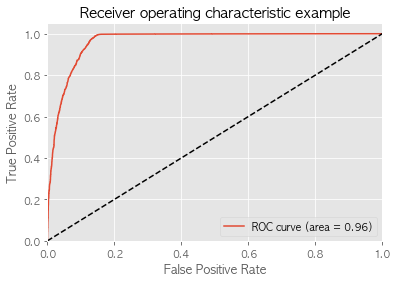

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_probs, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

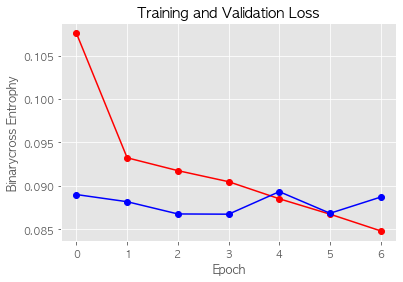

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label = 'train_loss')
plt.plot(val_loss, 'bo-', label = 'val_loss')
plt.ylabel('Binarycross Entrophy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

#overfitting이 되고 있다.

In [56]:
pred_probs = model.predict(X_test)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[[1.   ]
 [0.019]
 [0.983]
 [0.039]
 [0.864]
 [0.891]
 [0.006]
 [0.99 ]
 [0.95 ]
 [0.993]]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 0, 1, 1, 1]


In [57]:
get_clf_eval(y_test, preds)

오차행렬:
 [[ 3696   681]
 [  109 32317]]

정확도: 0.9785
정밀도: 0.9794
재현율: 0.9966
F1: 0.9879
AUC: 0.9205


In [58]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

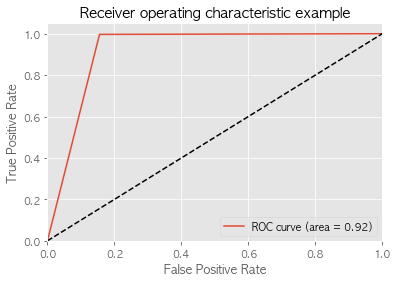

In [59]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()